In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("..")
from audio import *

In [3]:
PATH_BASE = Path('/home/jupyter/rob/googlespeech/')
PATH_TEST = PATH_BASE/'test/'
PATH_DATA = PATH_BASE/'train/cleanaudio/'
PATH_TRAINTEST = PATH_BASE/'train/testaudio'

In [4]:
PATH_DATA.ls()

[PosixPath('/home/jupyter/rob/googlespeech/train/cleanaudio/stop'),
 PosixPath('/home/jupyter/rob/googlespeech/train/cleanaudio/off'),
 PosixPath('/home/jupyter/rob/googlespeech/train/cleanaudio/on'),
 PosixPath('/home/jupyter/rob/googlespeech/train/cleanaudio/silence'),
 PosixPath('/home/jupyter/rob/googlespeech/train/cleanaudio/yes'),
 PosixPath('/home/jupyter/rob/googlespeech/train/cleanaudio/right'),
 PosixPath('/home/jupyter/rob/googlespeech/train/cleanaudio/unknown'),
 PosixPath('/home/jupyter/rob/googlespeech/train/cleanaudio/no'),
 PosixPath('/home/jupyter/rob/googlespeech/train/cleanaudio/left'),
 PosixPath('/home/jupyter/rob/googlespeech/train/cleanaudio/go'),
 PosixPath('/home/jupyter/rob/googlespeech/train/cleanaudio/up'),
 PosixPath('/home/jupyter/rob/googlespeech/train/cleanaudio/down')]

In [5]:
len(Path(PATH_DATA/"stop").ls())

2380

There are some samples in the final test set that are silence but are pure zeros. A trained model won't recognize them well unless we feed similar data into the training set.

In [14]:
# for i in range(150):
#     sig = torch.zeros([16000]).unsqueeze(0)
#     torchaudio.save(str(PATH_DATA/f"silence/pure_zeros{i}.wav"), sig, 16000)

In [7]:
sg_cfg= SpectrogramConfig(hop=126, n_mels=128, n_fft=1600, f_max=8000, top_db=100)
cfg = AudioConfig(remove_silence=False, cache=True, segment_size=None, 
                           max_to_pad=1003, resample_to=16000, mfcc=True, delta=True, 
                           duration=None, sg_cfg=sg_cfg)

In [8]:
cfg.cache_dir

PosixPath('.cache')

In [15]:
#! rm -rf {cfg.cache_dir}

In [16]:
cfg._sr

In [17]:
data_pct = 1

In [18]:
al_train = AudioList.from_folder(PATH_DATA, config=cfg).use_partial_data(data_pct)
#al_traintest = AudioList.from_folder(PATH_TRAINTEST, config=cfg)

In [19]:
al_train

AudioList (66670 items)
AudioItem 1.0 seconds (16047 samples @ 16000hz),AudioItem 1.0 seconds (44232 samples @ 44100hz),AudioItem 1.0 seconds (16047 samples @ 16000hz),AudioItem 1.0 seconds (16047 samples @ 16000hz),AudioItem 1.0 seconds (16047 samples @ 16000hz)
Path: /home/jupyter/rob/googlespeech/train/cleanaudio

In [20]:
al = al_train.split_by_rand_pct(0.2).label_from_folder()

/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]


In [21]:
tfms = None

In [22]:
db_audio = al.transform(tfms).databunch(bs=256)

In [23]:
db_audio.show_batch(8)

------------------------------------------------------------
File: /home/jupyter/rob/googlespeech/train/cleanaudio/.cache/rs_16000/up-0f3f64d5_nohash_2.wav-ee95affdf6bbb59e03a6c38c42b20ca9/0.wav
Total Length: 1.0029375 seconds
Label: up


------------------------------------------------------------
File: /home/jupyter/rob/googlespeech/train/cleanaudio/.cache/rs_16000/silence-chunk_61976.wav-ddbd33b426e9e81ff468c930518e8752/0.wav
Total Length: 1.0029375 seconds
Label: silence


------------------------------------------------------------
File: /home/jupyter/rob/googlespeech/train/cleanaudio/.cache/rs_16000/four-aa233654_nohash_0.wav-9a395566e3033ec004a9046cde91b7c8/0.wav
Total Length: 1.0029375 seconds
Label: unknown


------------------------------------------------------------
File: /home/jupyter/rob/googlespeech/train/cleanaudio/.cache/rs_16000/three-9190045a_nohash_0.wav-2dc0644cbf746bfda0b55dcbbbdbcdad/0.wav
Total Length: 1.0029375 seconds
Label: unknown


------------------------------------------------------------
File: /home/jupyter/rob/googlespeech/train/cleanaudio/.cache/rs_16000/go-7195ffa6_nohash_0.wav-3af25a1710104bc4c58c3f90c72c200d/0.wav
Total Length: 1.0029375 seconds
Label: go


------------------------------------------------------------
File: /home/jupyter/rob/googlespeech/train/cleanaudio/.cache/rs_16000/eight-c7aaad67_nohash_3.wav-121dad94cb96ce43077c02f7b6865ee9/0.wav
Total Length: 1.0029375 seconds
Label: unknown


------------------------------------------------------------
File: /home/jupyter/rob/googlespeech/train/cleanaudio/.cache/rs_16000/marvin-4abefdf5_nohash_0.wav-6d5f6ee833665d5721b5ab9cc27eb1a4/0.wav
Total Length: 1.0029375 seconds
Label: unknown


------------------------------------------------------------
File: /home/jupyter/rob/googlespeech/train/cleanaudio/.cache/rs_16000/yes-dbb40d24_nohash_3.wav-f7185c93bf5fa3a40112a3a476f75252/0.wav
Total Length: 1.0029375 seconds
Label: yes


In [29]:
from fastai.callbacks import *
learn = audio_learner(db_audio, models.resnet50, metrics=accuracy,callback_fns=[partial(CSVLogger, append=True)], pretrained=True).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


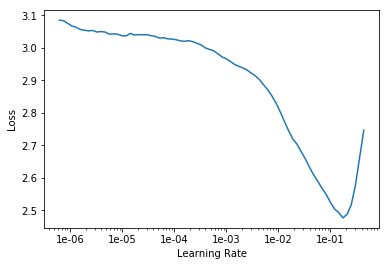

In [27]:
learn.lr_find()
learn.recorder.plot()

In [25]:
def shutdown_after_completion():
    !sudo shutdown -h now

In [30]:
learn.fit_one_cycle(20, max_lr=slice(3e-2), callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,1.485295,1.284431,0.644743,00:55
1,1.230804,0.911234,0.711564,00:48
2,0.956476,0.541527,0.829084,00:48
3,0.783740,0.369845,0.890280,00:49
4,0.718054,0.339395,0.899730,00:49
5,0.687227,0.314033,0.904005,00:49
6,0.646689,0.281248,0.920429,00:49
7,0.633938,0.263226,0.929879,00:49
8,0.617563,0.275356,0.931603,00:49
9,0.591657,0.232786,0.941803,00:49


Better model found at epoch 0 with accuracy value: 0.6447427868843079.
Better model found at epoch 1 with accuracy value: 0.7115644216537476.
Better model found at epoch 2 with accuracy value: 0.8290835618972778.
Better model found at epoch 3 with accuracy value: 0.8902804851531982.
Better model found at epoch 4 with accuracy value: 0.8997300267219543.
Better model found at epoch 5 with accuracy value: 0.9040048122406006.
Better model found at epoch 6 with accuracy value: 0.920428991317749.
Better model found at epoch 7 with accuracy value: 0.9298785328865051.
Better model found at epoch 8 with accuracy value: 0.9316034317016602.
Better model found at epoch 9 with accuracy value: 0.9418029189109802.
Better model found at epoch 10 with accuracy value: 0.9421029090881348.
Better model found at epoch 11 with accuracy value: 0.9475775957107544.
Better model found at epoch 12 with accuracy value: 0.9544022679328918.
Better model found at epoch 13 with accuracy value: 0.9561271667480469.
Bet

In [31]:
learn.lr_find(start_lr=1e-04, end_lr=1e-02)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


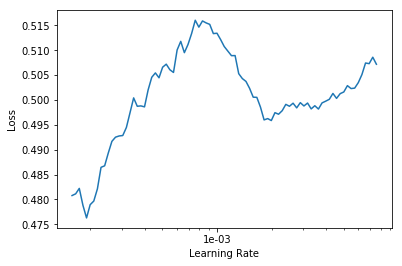

In [32]:
learn.recorder.plot()

In [33]:
learn.export(PATH_BASE/"models/google-mfcc-resnet-self-train-rd1.pkl")

In [36]:
def self_train():
    path_best = PATH_DATA/"models/bestmodel"
    learn.load(path_best)
    learn.unfreeze()
    learn.fit_one_cycle(100, max_lr=slice(2e-3), callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy')], div_factor=15)
    learn.load(path_best)
    learn.export(PATH_BASE/"models/google-mfcc-resnet-self-train-rd2.pkl")
    learn.unfreeze()
    
    learn.load(path_best)
    learn.fit_one_cycle(200,max_lr=slice(9e-4), callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy')], div_factor=15)
    learn.load(path_best)
    learn.export(PATH_BASE/"models/google-mfcc-resnet-self-train-rd3.pkl")
    
    shutdown_after_completion()

In [ ]:
self_train()

epoch,train_loss,valid_loss,accuracy,time
0,0.498540,0.221090,0.964677,01:03
1,0.488314,0.176392,0.963252,01:02
2,0.484868,0.157928,0.963027,01:02
3,0.480094,0.147063,0.962952,01:03
4,0.470076,0.150595,0.964602,01:03
5,0.471235,0.155085,0.964002,01:03
6,0.464100,0.201501,0.961602,01:03
7,0.469531,0.158822,0.962202,01:03
8,0.468091,0.148516,0.964302,01:03
9,0.465628,0.152427,0.960477,01:03


Better model found at epoch 0 with accuracy value: 0.9646767377853394.
Better model found at epoch 10 with accuracy value: 0.9650517702102661.
Better model found at epoch 11 with accuracy value: 0.965576708316803.
Better model found at epoch 13 with accuracy value: 0.9708264470100403.
Better model found at epoch 24 with accuracy value: 0.9712014198303223.
Better model found at epoch 29 with accuracy value: 0.9733763337135315.
Better model found at epoch 33 with accuracy value: 0.9759262204170227.
Better model found at epoch 35 with accuracy value: 0.9763011932373047.
Better model found at epoch 41 with accuracy value: 0.9775011539459229.
Better model found at epoch 43 with accuracy value: 0.9775761365890503.
Better model found at epoch 45 with accuracy value: 0.9782510995864868.
Better model found at epoch 55 with accuracy value: 0.979826033115387.
Better model found at epoch 60 with accuracy value: 0.9814009070396423.
Better model found at epoch 71 with accuracy value: 0.9816259145736

epoch,train_loss,valid_loss,accuracy,time
0,0.316757,0.093939,0.983876,01:03
1,0.320103,0.093537,0.983876,01:03
2,0.317849,0.091588,0.983951,01:03
3,0.317059,0.091199,0.983726,01:03
4,0.319392,0.092820,0.983351,01:03
5,0.317498,0.093668,0.983876,01:03
6,0.315137,0.093083,0.983126,01:03
7,0.318882,0.092801,0.983501,01:03
8,0.320814,0.093763,0.983201,01:03
9,0.314824,0.094542,0.983501,01:03


Better model found at epoch 0 with accuracy value: 0.9838758111000061.
Better model found at epoch 2 with accuracy value: 0.9839507937431335.


epoch,train_loss,valid_loss,accuracy,time
0,0.697051,0.489020,0.865922,00:02
1,0.700552,0.479120,0.882682,00:02
2,0.709135,0.461606,0.877095,00:02
3,0.697269,0.445287,0.882682,00:02
4,0.695103,0.442005,0.874302,00:02
5,0.692333,0.454778,0.891061,00:02
6,0.696674,0.515599,0.874302,00:02
7,0.694127,0.955991,0.849162,00:02
8,0.685964,0.946894,0.865922,00:02
9,0.689233,0.516933,0.854749,00:02


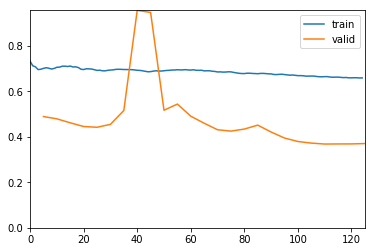

In [58]:
learn.fit_one_cycle(25, max_lr=slice(5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.649810,0.369488,0.891061,00:02
1,0.662475,0.367259,0.888268,00:02
2,0.652364,0.368138,0.888268,00:02
3,0.650286,0.367588,0.882682,00:02
4,0.650563,0.364748,0.882682,00:02
5,0.646342,0.366307,0.879888,00:02
6,0.646380,0.364321,0.882682,00:02
7,0.642960,0.362011,0.885475,00:02
8,0.641979,0.364498,0.882682,00:02
9,0.637363,0.363371,0.888268,00:02


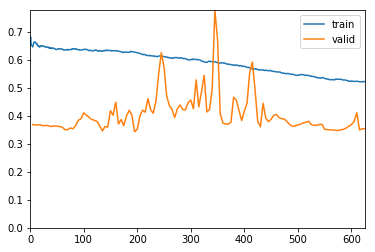

In [59]:
learn.fit_one_cycle(125, max_lr=slice(3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.519602,0.354349,0.921788,00:02
1,0.525576,0.357672,0.921788,00:02
2,0.519365,0.364068,0.924581,00:02
3,0.526116,0.374850,0.924581,00:02
4,0.528083,0.351700,0.924581,00:02
5,0.527876,0.351859,0.924581,00:02
6,0.531151,0.357478,0.921788,00:02
7,0.531503,0.361314,0.924581,00:02
8,0.529484,0.363479,0.924581,00:02
9,0.526939,0.365044,0.924581,00:02


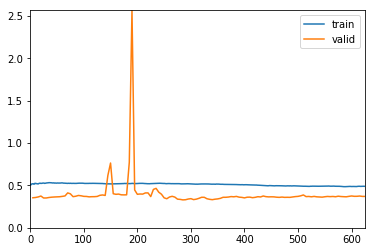

In [60]:
learn.fit_one_cycle(125, max_lr=slice(1e-3), div_factor=7)

torch.Size([1, 224, 267])


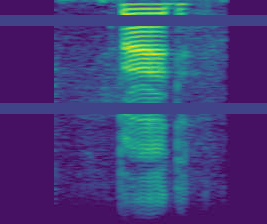

In [154]:
bs = 128
tfm_sg_shift.use_on_y = False
tfm_sg_aug.use_on_y = False
tfms = [tfm_sg_aug], []
db = label_data.transform(tfms).databunch(bs=bs)
print(db.train_ds[1][0].shape)
db.train_ds[20][0].show()

In [155]:
learn = audio_learner(db)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


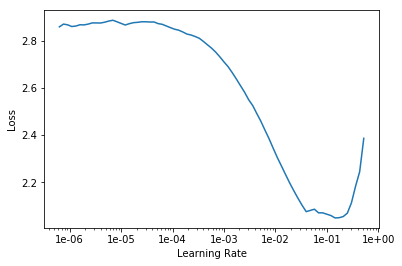

In [156]:
learn.lr_find()
learn.recorder.plot()

In [157]:
sharp = slice(1e-3, 1e-2)
base = slice(1e-4, 4e-3)
wide = slice(3e-4, 1e-2)
learn.fit_one_cycle(20, sharp)

epoch,train_loss,valid_loss,accuracy,time
0,2.579870,2.457310,0.101338,00:04
1,2.023831,2.530479,0.210325,00:04
2,1.439896,2.689427,0.326960,00:04
3,1.062681,0.707382,0.793499,00:04
4,0.806942,0.493500,0.837476,00:04
5,0.651600,2.201286,0.636711,00:04
6,0.536320,0.728474,0.799235,00:04
7,0.446155,0.526748,0.868069,00:04
8,0.367041,0.376579,0.885277,00:04
9,0.300504,0.300115,0.915870,00:04


[('tree', 'three', 2),
 ('bird', 'bed', 1),
 ('dog', 'off', 1),
 ('no', 'down', 1),
 ('on', 'bird', 1),
 ('on', 'dog', 1),
 ('on', 'down', 1),
 ('one', 'on', 1),
 ('three', 'bird', 1),
 ('three', 'tree', 1)]

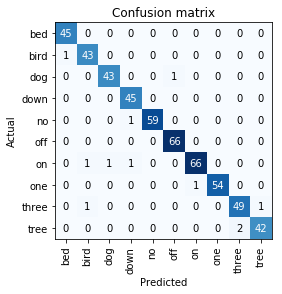

In [158]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused()